In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from warnings import simplefilter
from scipy.ndimage.interpolation import shift
from sklearn.datasets import fetch_openml # mnist dataset
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score,roc_auc_score

In [2]:
# Ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Get MNIST Data

In [3]:
mnist = fetch_openml("mnist_784", version = 1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8) # y is string, make them integers

# Data is already splitted into training and test sets:
    # First 60.000 -> training, last 10.000 -> test  
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [4]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
def threshold(thr):
    return (y_scores > thr)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],"b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    # highlighting the threshold, add legend, axis label and grid
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)          
    plt.axis([-50000, 50000, 0, 1])
    
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR) (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR) (Recall)', fontsize=16)
    plt.grid(True)  

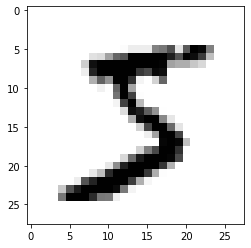

Example image label: 5


In [5]:
example = X[0]
# Reshape the feature vector to a 28 x 28 array to see it as a digit
example_image = example.reshape(28,28)
# Show the example image
plt.imshow(example_image, cmap = mpl.cm.binary, interpolation= "nearest")
plt.show()
print("Example image label:", y[0])

# TRAINING A BINARY CLASSIFIER

In [6]:
# Identify only one digit: 5 --> only 2 classes : 5 or not 5
    # True for all 5s, False for other digits
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## Stochastic Gradient Descent (SGD)

In [7]:
sgd_clf = SGDClassifier(random_state = 42) # SGD relies on randomness
sgd_clf.fit(X_train, y_train_5)
# Detect the example digit
sgd_clf.predict([example])

array([ True])

# Performance Measures

## Accuracy using CV

In [8]:
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

## Confusion Matrix

In [9]:
y_tr_preds = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
confusion_matrix(y_train_5,y_tr_preds)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [10]:
print("Precision(TP/(TP+FP)):", precision_score(y_train_5,y_tr_preds))
print("Recall(TP/(TP+FN)):", recall_score(y_train_5, y_tr_preds))
print("F1 Score:",f1_score(y_train_5,y_tr_preds))

Precision(TP/(TP+FP)): 0.8370879772350012
Recall(TP/(TP+FN)): 0.6511713705958311
F1 Score: 0.7325171197343846


## Precision/Recall Tradeoff

In [11]:
y_scores = sgd_clf.decision_function([example])
print("When threshold = 0:", threshold(0))
print("When threshold = 8000:", threshold(8000))

When threshold = 0: [ True]
When threshold = 8000: [False]


#### How to decide which threshold to use?

In [12]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

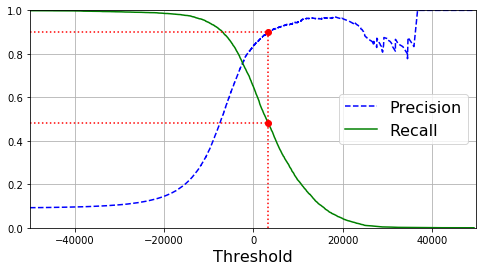

In [13]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

In [14]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


## The ROC Curve

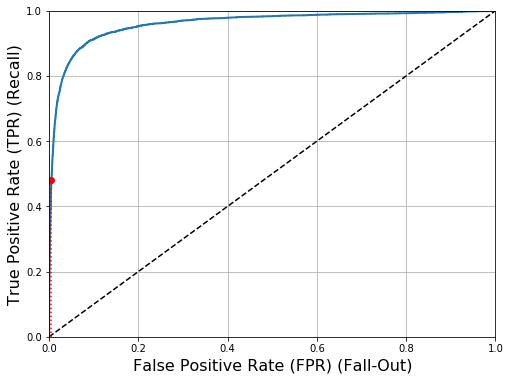

In [15]:
# Compute true positive rate (TPR) and false positive rate (FPR)
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

In [16]:
# ROC AUC score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## Random Forest Classifier

In [17]:
forest_clf = RandomForestClassifier(random_state = 42)

# RandomForestClassifier has predict_proba() instead of decision_function()
y_probas = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                             method = "predict_proba")

In [18]:
# For plotting the ROC we need scores, not probas
y_scores_forest = y_probas[:,1] # posittive class' probs
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

#### Comparing SGD and Random Forest with their ROC curves

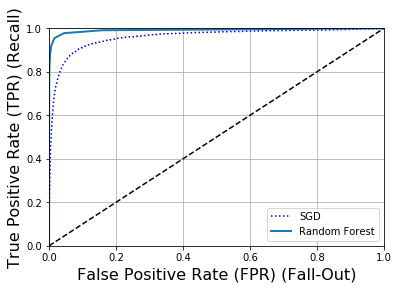

In [19]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

#### Comparing SGD and Random Forest with their ROC AUC scores

In [20]:
print("Random Forest AUC:", roc_auc_score(y_train_5, y_scores_forest))
print("SGD AUC:", roc_auc_score(y_train_5, y_scores))

Random Forest AUC: 0.9920527492698306
SGD AUC: 0.9604938554008616


# MULTICLASS CLASSIFICATION

## Stochastic Gradient Descent (SGD)

In [21]:
sgd_clf.fit(X_train, y_train)
# Detect the example digit
sgd_clf.predict([example])

array([3], dtype=uint8)

In [22]:
y_scores = sgd_clf.decision_function([example])
y_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [23]:
indx = np.argmax(y_scores)
print(sgd_clf.classes_[indx])

3


In [24]:
# Evaluation (Accuracy using CV)
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.87082583, 0.87089354, 0.88628294])

In [25]:
# Evaluation (Accuracy using CV) after scaling the inputs
scaler = StandardScaler()
x_tr_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, x_tr_scaled, y_train, cv = 3, scoring = "accuracy")

C:\Users\esra\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

#### One-versus-one classifier

In [26]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([example])

array([5], dtype=uint8)

## Random Forest Classifier

In [27]:
forest_clf.fit(X_train, y_train)
# Detect the example digit
forest_clf.predict([example])

array([5], dtype=uint8)

In [28]:
# Get the list of probabilities that the classifier assigned to each instance for each class:
forest_clf.predict_proba([example])

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

## Error Analysis

In [29]:
y_tr_pred = cross_val_predict(sgd_clf, x_tr_scaled, y_train, cv = 3)
# Confusion matrix
conf_mat = confusion_matrix(y_train, y_tr_pred)
conf_mat

C:\Users\esra\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]],
      dtype=int64)

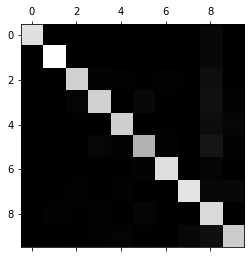

In [30]:
# Image represantation of the confusion matrix
plt.matshow(conf_mat, cmap=plt.cm.gray)
plt.show()

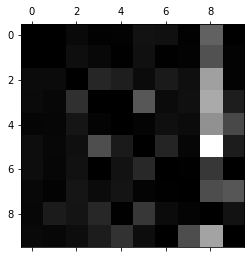

In [31]:
# Divide each value in the confusion matrix by the number of images in the corresponding class
row_sums = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat / row_sums
# Fll the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mat, 0)
# Plot the results
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.show()

# MULTILABEL CLASSIFICATION

In [32]:
y_large = (y_train >= 7)
y_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_large, y_odd]

## KNeighbors Classifier

In [33]:
# KNeighborsClassifier supports multilabel classification
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
# Detect the example digit
knn_clf.predict([example])

array([[False,  True]])

In [34]:
# Evaluation with F1 Score
y_tr_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_tr_knn_pred, average = "macro")

0.976410265560605

# MULTIOUTPUT CLASSIFICATION

### Removing noise from images

In [35]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_noisy = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_noisy= X_test + noise
y_train_noisy = X_train
y_test_noisy = X_test

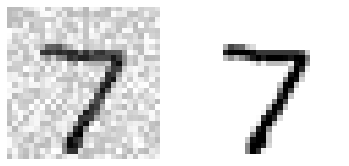

In [37]:
plt.subplot(121)
plot_digit(X_test_noisy[0])
plt.subplot(122)
plot_digit(y_test_noisy[0])
plt.show()

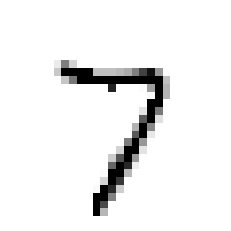

In [38]:
# Train the classifier and make the images clean
knn_clf.fit(X_train_noisy, y_train_noisy)
clean_digit = knn_clf.predict([X_test_noisy[0]])
plot_digit(clean_digit)

### 1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set.
### Hint: the KNeighborsClassifier works quite well for this task; You just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [39]:
param_grid = [{"n_neighbors": [3, 4, 5], "weights": ["uniform", "distance"]}]
grid_search = GridSearchCV(knn_clf, param_grid, cv = 5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [40]:
# Best combination of parameters
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [41]:
knn_final_model = grid_search.best_estimator_
knn_predicts = knn_final_model.predict(X_test)
accuracy_score(y_test, knn_predicts)

0.9714

### 2. Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

In [42]:
def shift_image(img, dx, dy):
    shifted = shift(img.reshape((28, 28)), [dy, dx], cval=0, mode="constant")
    return shifted.reshape([-1])

In [43]:
my_img = X_train[1500]
# Shifted to the left by 5 pixels
shift_left = shift_image(my_img, -5,0)
# Shifted to the right by 5 pixels
shift_right = shift_image(my_img, 5,0)
# Shifted up by 5 pixels
shift_up = shift_image(my_img, 0,-5)
# Shifted down by 5 pixels
shift_down = shift_image(my_img, 0,5)

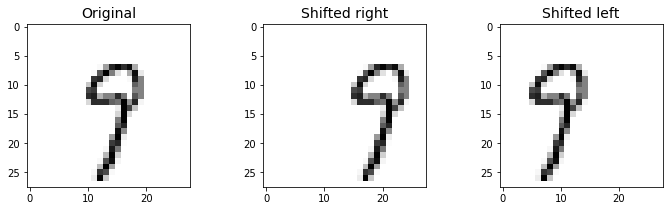

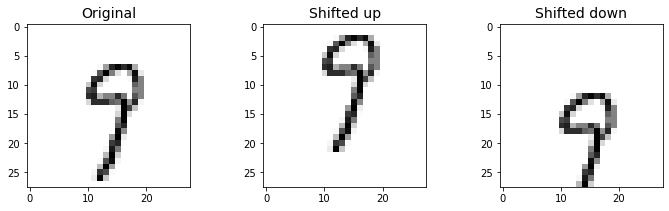

In [44]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(my_img.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted right", fontsize=14)
plt.imshow(shift_right.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shift_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(my_img.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted up", fontsize=14)
plt.imshow(shift_up.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted down", fontsize=14)
plt.imshow(shift_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [45]:
X_augmented = [image for image in X_train]
y_augmented = [label for label in y_train]
# Append shifted copies
for x,y in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_augmented.append(shift_image(image, x, y))
        y_augmented.append(label)
        
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

In [46]:
# Shuffling indexes
shuffled = np.random.permutation(len(X_augmented))
X_augmented = X_augmented[shuffled]
y_augmented = y_augmented[shuffled]

In [47]:
# Training the best model on the augmented training set
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_augmented, y_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [48]:
# Measure its accuracy on the test set
predictions = knn_clf.predict(X_test)
accuracy_score(y_test, predictions)

0.9763